##  Project Description

Investment firms, hedge funds and even individuals have been using financial models to better understand market behavior and make profitable investments and trades. A wealth of information is available in the form of historical stock prices and company performance data, suitable for machine learning algorithms to process.
For this project, the task is to build a stock price predictor that takes daily trading data over a certain date range as input, and outputs projected estimates for given query dates.

The inputs will contain multiple metrics, such as opening price (Open), highest price the stock traded at (High), how many stocks were traded (Volume) and closing price adjusted for stock splits and dividends (Adjusted Close); we are only  predicting the Adjusted Close price.

The project will use a simple script.
1. Training Script:
   Does the Model training and saves the model, it also returns the error rate for the predicted days
   
2. Prediction script:
   Takes the saved model and forecast the price of the stocks provided
   NB:For you to forecast a given stock, need to have trained a model for that specific stock
   
 

In [29]:
#from urllib.parse import urlencode
#from pandas_datareader import data

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from datetime import date
from datetime import datetime
from datetime import timedelta

from tsfresh import extract_features
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

from tsfresh.transformers import RelevantFeatureAugmenter

import plotly.io as pio
from dateutil.relativedelta import relativedelta, MO
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go


from prophet import Prophet


from pandas_datareader import data
import statsmodels.api as sm


#### Load Data

Start by loading data using an API from the yahoo site.

We are only taking a sample of the stock for the puopose of model training and tuning

In [5]:
def load_data(symbols, start_date, end_date):
      """
      INPUT:
      tickers : list containing the tickers of the stocks whose prices will be predicted
      start_date : initial date to gather data
      end_data : final date to gather data
      OUTPUT:
      prices_base : dataframe containing the adjusted closing price for the stocks
                    on the desired time frame
      """
      df = data.DataReader(
          symbols,
          'yahoo',
          start_date,
          end_date)

      df = pd.DataFrame(df)
      df_base = df['Adj Close']
    
      try: 
            
           df_prices = df_base.stack()
           df_prices = pd.DataFrame(df_prices)
           df_prices.columns = ['y']
        
      except:
        df = pd.DataFrame(df_base)
        df['Symbols'] = symbols
        df.rename(columns= {'Adj Close':'y'},inplace = True)
        df_prices = df
        
      #print(df_prices)

      df_prices.reset_index(inplace=True)
      df_prices = df_prices.sort_values(by = ['Symbols','Date'])
      df_prices.rename(columns = {'Date':'ds'},inplace = True)
      
      

      return df_prices


In [7]:
df = load_data(['GOOGL','AAPL'],'2019-05-01','2022-01-01')

### Features
Create time features that will be used as inputs to the model.

Time features are good in timeseries because.
1. You can generate the features even for the future dates.
2. Most of the time series are seasonal and therefore time features are able to capture such aspects of the response variable

NB: Will create as many as we can and keep only thoes that will be siggnificant for the model


In [14]:
def create_time_features(df):
    
    df['dayofweek'] = df['ds'].dt.dayofweek
    df['quarter'] = df['ds'].dt.quarter
    df['month'] = df['ds'].dt.month
    df['year'] = df['ds'].dt.year
    df['dayofyear'] = df['ds'].dt.dayofyear
    df['sin_day'] = np.sin(df['dayofyear'])
    df['cos_day'] = np.cos(df['dayofyear'])
    df['dayofmonth'] = df['ds'].dt.day
    df['weekofyear'] = df['ds'].dt.weekofyear
    df=df.sort_values('ds')
    return df  

In [15]:
df = create_time_features(df)

/Users/dgitahi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



## Exploratory Data Analysis

In [17]:
df.head()

,ds,Symbols,y,dayofweek,quarter,month,year,dayofyear,sin_day,cos_day,dayofmonth,weekofyear
1,2019-05-01,AAPL,51.245850,2,2,5,2019,121,0.998815,-0.048664,1,18
0,2019-05-01,GOOGL,1173.319946,2,2,5,2019,121,0.998815,-0.048664,1,18
2,2019-05-02,GOOGL,1166.510010,3,2,5,2019,122,0.498713,-0.866767,2,18
3,2019-05-02,AAPL,50.912350,3,2,5,2019,122,0.498713,-0.866767,2,18
5,2019-05-03,AAPL,51.545261,4,2,5,2019,123,-0.459903,-0.887969,3,18


In [22]:
df_viz

[['Symbols', 'y']]

AAPL


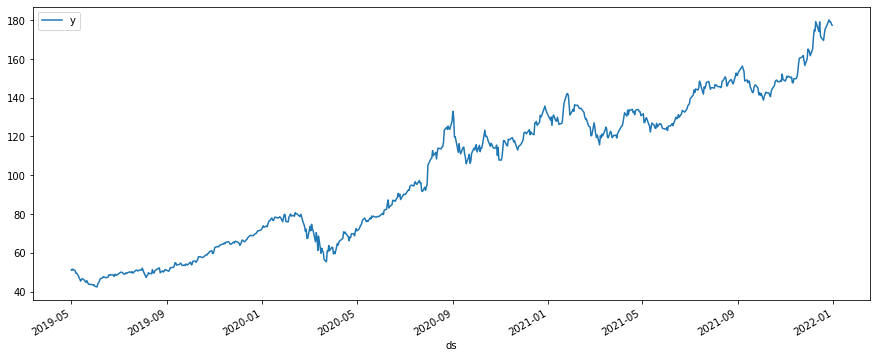

GOOGL


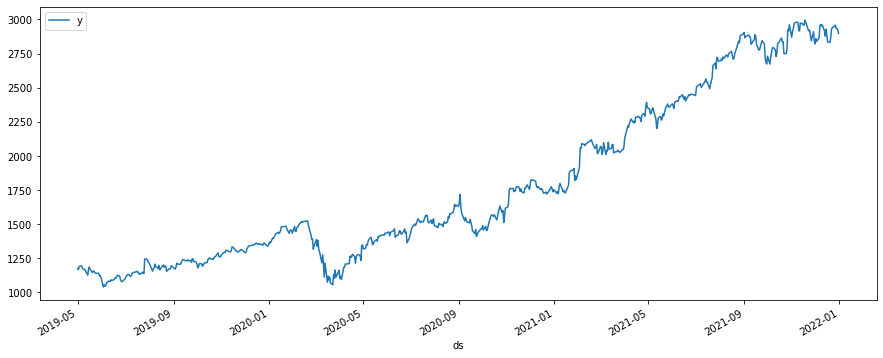

In [27]:
df_viz = df.set_index('ds')
df_viz= df_viz[['Symbols','y']]
for symbol in df.Symbols.unique():
    df_ = df_viz[df_viz.Symbols==symbol]
    print(symbol)
    df_.plot(kind = 'line',figsize=(15, 6))
    plt.show()
    
#     df_ = df[df.Symbols==symbol]
#     df_.sort_values(by = 'ds',inplace=True)
    


#     fig = go.Figure(layout={'width' :1000,'height':500})

#     fig.add_trace(go.Scatter(x=df_.ds,y=df_.y,
#                         mode='lines+markers',
#                         name='Price'))

#     #     fig.add_trace(go.Scatter(x=df.ds,y=df.yhat_lower,
#     #                         mode='lines+markers',
#     #                         name='lower_boundary'))

#     #     fig.add_trace(go.Scatter(x=df.ds,y=df.yhat_upper,
#     #                         mode='lines+markers',
#     #                         name='upper_boundary'))

#     fig.update_layout(title = symbol,
#                      yaxis_title = "Price")
#     fig.show()

    #fig.update_yaxes(range=[10000, 800000])


From the above tread there is a change i trend from the Year 2020.

Will therefor confine the trainig data from year 2020 going forward.

In [42]:
df_

,y
ds,
2019-05-01,51.245850
2019-05-02,50.912350
2019-05-03,51.545261
2019-05-06,50.749268
2019-05-07,49.381207
...,...
2021-12-27,180.100540
2021-12-28,179.061859
2021-12-29,179.151749


##### Seasonality

In [46]:
df_= pd.DataFrame(df_)

In [48]:
decomposition = sm.tsa.seasonal_decompose(df_, model='additive',freq =20)

AAPL


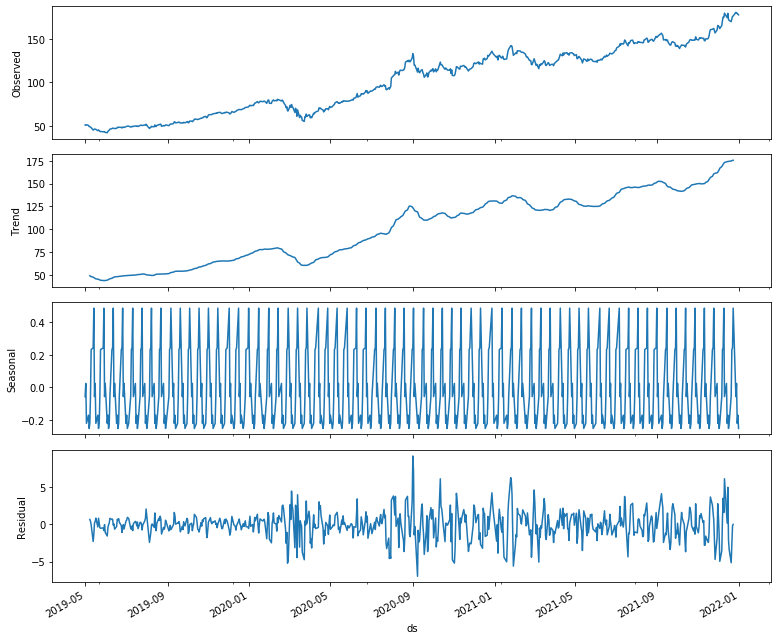

GOOGL


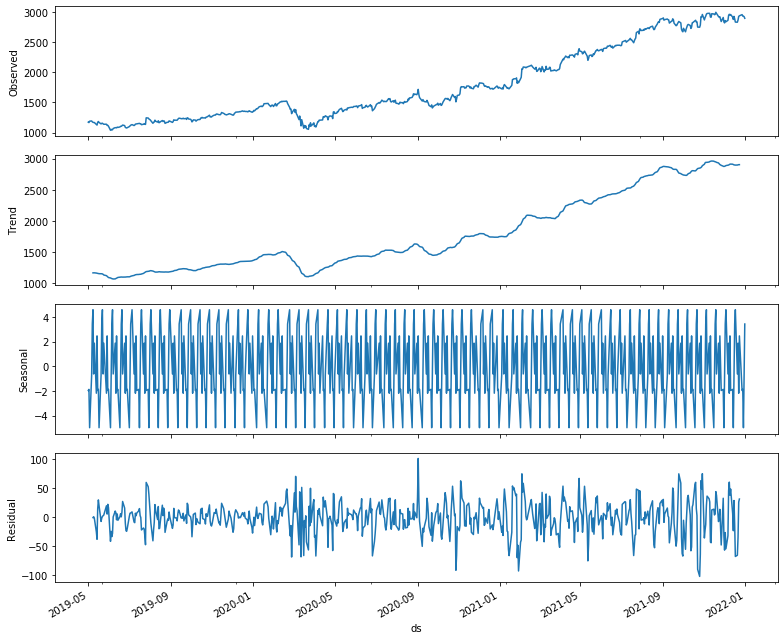

In [56]:
from pylab import rcParams
rcParams['figure.figsize'] = 11, 9


for symbol in df.Symbols.unique():
    print(symbol)
    df_ = df_viz[df_viz.Symbols==symbol]
    df_ = df_[['y']]
    
    decomposition = sm.tsa.seasonal_decompose(df_, model='additive',freq=10)
    fig = decomposition.plot()
    plt.show()

There is a strong seasonal component

The stocks also show a increasing trend, therefore the series is not stationary. 

If we are to use parametric method we need to detrend the series, so that we can fit the stationary model


### Model Training

We tested 2 Models:
1. Facebook Prophet:
   The model was good especially capturing the seasonality part of the series, though it was not able to adjust to quick changes on the trend therefore leading to high errors in such instances
   
   
2. Randomforest Regressor. It was able to capture the pattern especially when we added the time features. The out of box model with just a sligt increase of the number of trees from 100 to 120, was able to meet the set target of about 5% errror rate.


NB We therefore use the RandomForest regressor as the final model.

In [57]:
### Fit a prophet model

In [394]:
df_train = df[df.Symbols=='BAC']

In [559]:
def model_build():

    model= Prophet(seasonality_mode='additive')
   
    return model
model = model_build()

In [560]:
def split_data(test_size, df):
    """
    Split data into training and testing sets
    INPUT:
    test_size - size of testing data in ratio (default = 0.2)
    df - cleaned and processed dataframe
    OUTPUT:
    train - training data set
    test - testing data set

    """
    
#     test_size = test_size
#     training_size = 1 - test_size

#     test_num = int(test_size * len(df))
#     train_num = int(training_size * len(df))

    train_size = len(df)-test_size
    train = df[:train_size].drop(columns= ['Symbols'])
    test = df[train_size:].drop(columns= ['Symbols'])
    

    return train, test 

In [443]:
train, test  =split_data(30,df_train)

In [444]:
#

In [445]:
model.fit(train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [446]:
 df_pred = model.predict(test)

In [561]:
def evalute_model(test):
        df_pred = model.predict(test)
        df_pred =pd.merge(df_pred,test,on='ds',how = 'inner')
        df_pred = df_pred[['ds','yhat','y']]
        mape = abs(df_pred['yhat']-df_pred['y'])/df_pred['y']*100
        df_pred['mean_absolute_error'] = mape
        avg_mape = round(df_pred.mean_absolute_error.mean())
        #print('mean error for the period {}%'.format(avg_mape))
        return df_pred,avg_mape


#df_pred,avg_mape = evalute_model(test)  

In [427]:
df = load_data(['GOOGL','AAPL','BAC','ORCL','MSFT'],'2019-05-01','2022-01-01')
df = create_time_features(df)

/Users/dgitahi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



In [564]:
error = []
symbols = df.Symbols.unique()
for symbol in symbols:
    df_train = df[df.Symbols==symbol]
    
    model = model_build()
    
    train, test  =split_data(7,df_train)
    model.fit(train)
    df_pred = model.predict(test)
    
    df_pred,avg_mape = evalute_model(test)
    error.append(avg_mape)
    
pd.DataFrame({'Symbol':symbols,'Error':error}) 

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,Symbol,Error
0,AAPL,4
1,MSFT,2
2,GOOGL,1
3,BAC,7
4,ORCL,11


#### ADDING TIME FEATURES TO THE MODEL

In [474]:
def model_build():
    model = Prophet(seasonality_mode='additive')
    model.add_regressor('dayofweek')
    #model.add_regressor('quarter')
    #model.add_regressor('month')
    model.add_regressor('year')
    #model.add_regressor('dayofyear')
    model.add_regressor('sin_day')
    model.add_regressor('cos_day')
    model.add_regressor('weekofyear')

    return model

In [58]:
error = []
symbols = df.Symbols.unique()
for symbol in symbols:
    df_train = df[df.Symbols==symbol]
    
    model = model_build()
    
    train, test  =split_data(7,df_train)
    model.fit(train)
    df_pred = model.predict(test)
    
    df_pred,avg_mape = evalute_model(test)
    error.append(avg_mape)
    
pd.DataFrame({'Symbol':symbols,'Error':error})

NameError: name 'model_build' is not defined

In [436]:
df

,ds,Symbols,y,dayofweek,quarter,month,year,dayofyear,sin_day,cos_day,dayofmonth,weekofyear
1,2019-05-01,AAPL,51.245846,2,2,5,2019,121,0.998815,-0.048664,1,18
4,2019-05-01,MSFT,123.931053,2,2,5,2019,121,0.998815,-0.048664,1,18
0,2019-05-01,GOOGL,1173.319946,2,2,5,2019,121,0.998815,-0.048664,1,18
2,2019-05-01,BAC,28.414230,2,2,5,2019,121,0.998815,-0.048664,1,18
3,2019-05-01,ORCL,52.468845,2,2,5,2019,121,0.998815,-0.048664,1,18
...,...,...,...,...,...,...,...,...,...,...,...,...
3372,2021-12-31,BAC,44.490002,4,4,12,2021,365,0.544046,0.839055,31,52
3370,2021-12-31,GOOGL,2897.040039,4,4,12,2021,365,0.544046,0.839055,31,52
3374,2021-12-31,MSFT,335.626038,4,4,12,2021,365,0.544046,0.839055,31,52
3371,2021-12-31,AAPL,177.344055,4,4,12,2021,365,0.544046,0.839055,31,52


### iterating on the Change point Prior and  and Seasonality Prior

In [437]:
cutoffs = pd.to_datetime(['2021-08-01', '2021-10-01','2021-11-01'])
symbol ='ORCL'
df_train = df[df.Symbols==symbol]
df_train = df.drop(columns='Symbols')

import itertools
from prophet.diagnostics import performance_metrics

from prophet.diagnostics import cross_validation

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01,0.05],
    'seasonality_prior_scale':[0.01,0.1,0.5,1,5 ,10],
    'seasonality_mode':['additive', 'multiplicative']
    
    
}


# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
mapes = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params)
    #m.add_seasonality(name='weekly',period= 7,fourier_order= 5,prior_scale = 0.5)
    m.fit(df_train)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    mapes.append(df_p['mape'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['mapes'] = mapes
print(tuning_results)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x1433cb128>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x140dd1a58>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x140c2aeb8>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x14102e400>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.p

    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  \
0                     0.001                     0.01         additive   
1                     0.001                     0.01   multiplicative   
2                     0.001                     0.10         additive   
3                     0.001                     0.10   multiplicative   
4                     0.001                     0.50         additive   
5                     0.001                     0.50   multiplicative   
6                     0.001                     1.00         additive   
7                     0.001                     1.00   multiplicative   
8                     0.001                     5.00         additive   
9                     0.001                     5.00   multiplicative   
10                    0.001                    10.00         additive   
11                    0.001                    10.00   multiplicative   
12                    0.010                     0.0

In [438]:
best_params = all_params[np.argmin(mapes)]
print(best_params)

{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive'}


In [472]:
def model_build():
    model = Prophet(seasonality_mode='additive',changepoint_prior_scale=0.001, seasonality_prior_scale= 0.01)
    model.add_regressor('dayofweek')
    model.add_regressor('quarter')
    model.add_regressor('month')
    model.add_regressor('year')
    model.add_regressor('dayofyear')
    model.add_regressor('sin_day')
    model.add_regressor('cos_day')
    #model.add_regressor('weekofyear')

    return model

In [473]:
error = []
symbols = df.Symbols.unique()
for symbol in symbols:
    df_train = df[df.Symbols==symbol]
    
    model = model_build()
    
    train, test  =split_data(30,df_train)
    model.fit(train)
    df_pred = model.predict(test)
    
    df_pred,avg_mape = evalute_model(test)
    error.append(avg_mape)
    
pd.DataFrame({'Symbol':symbols,'Error':error})

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,Symbol,Error
0,AAPL,3
1,MSFT,10
2,GOOGL,9
3,BAC,11
4,ORCL,11


### Model 2 

In [203]:
def load_data(start_date,end_date,symbols):
    """the functions read data from the yahoo website.
     and returns a dataframe
     
     Input: start date: date format
            end date : date format
            ticker: name of the stock: string
     Output: df_prices: datafame that has the prices"""
    df = data.DataReader(symbols,'yahoo',start_date,end_date)

    df = pd.DataFrame(df)
    df_base = df['Adj Close']
       
    df_base = df_base.stack()
    
    df_prices = pd.DataFrame(df_base)
    df_prices.columns = ['y']
    #print(df_prices)

    df_prices.reset_index(inplace=True)
    df_prices = df_prices.sort_values(by = ['Symbols','Date'])
    df_prices.rename(columns = {'Date':'ds'},inplace = True)
    
    return df_prices

In [206]:
###load data

df = load_data('2019-05-01','2022-01-01',['GOOGL'])

In [266]:
df.head()

,Adj Close,Symbols
Date,,
2021-01-04,128.453445,GOOGL
2021-01-05,130.041626,GOOGL
2021-01-06,125.664207,GOOGL
2021-01-07,129.952286,GOOGL
2021-01-08,131.073944,GOOGL


In [270]:
df.index.isocalendar().week

Date
2021-01-04    1
2021-01-05    1
2021-01-06    1
2021-01-07    1
2021-01-08    1
2021-01-11    2
2021-01-12    2
2021-01-13    2
2021-01-14    2
2021-01-15    2
2021-01-19    3
2021-01-20    3
2021-01-21    3
2021-01-22    3
2021-01-25    4
2021-01-26    4
2021-01-27    4
2021-01-28    4
2021-01-29    4
Name: week, dtype: UInt32

In [201]:
###time features
df = create_time_features(df)

/Users/dgitahi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



In [200]:
df_train = df[df.Symbols=='GOOGL']

In [187]:
def split_data(test_size, df):
    """
    Split data into training and testing sets
    INPUT:
    test_size - size of testing data in ratio (default = 0.2)
    df - cleaned and processed dataframe
    OUTPUT:
    train - training data set
    test - testing data set

    """
    
#     test_size = test_size
#     training_size = 1 - test_size

#     test_num = int(test_size * len(df))
#     train_num = int(training_size * len(df))
    df =df.set_index('ds')
    #df.drop(columns = ['year','month','quarter'],inplace = True)

    train_size = len(df)-test_size
    train = df[:train_size].drop(columns= ['Symbols'])
    test = df[train_size:].drop(columns= ['Symbols'])
    
    X_train=train.drop(columns='y')
    X_test =test.drop(columns='y')
    y_train = train['y']
    y_test = test['y']
    
    

    return X_train,y_train,X_test,y_test 

In [188]:
X_train,y_train,X_test,y_test =split_data_mdl2(7,df_train)

In [189]:
from sklearn.ensemble import RandomForestRegressor


def build_model():

    pipeline = Pipeline([
        ('clf', RandomForestRegressor(n_estimators=120))
    ]) 

    return pipeline

model =  build_model()   

In [190]:
import pickle

In [191]:
# def save_model():
#     filename = '/Users/dgitahi/Documents/nano degree/final_project/models/model.pkl'
#     pickle.dump(model, open(filename, 'wb'))
    


In [192]:
def save_model(model, model_filepath):
    with open(model_filepath, 'wb') as file:
        pickle.dump(model, file)


In [193]:
X_train

,dayofweek,quarter,month,year,dayofyear,sin_day,cos_day,dayofmonth,weekofyear
ds,,,,,,,,,
2019-05-01,2,2,5,2019,121,0.998815,-0.048664,1,18
2019-05-02,3,2,5,2019,122,0.498713,-0.866767,2,18
2019-05-03,4,2,5,2019,123,-0.459903,-0.887969,3,18
2019-05-06,0,2,5,2019,126,0.329991,0.943984,6,19
2019-05-07,1,2,5,2019,127,0.972630,0.232359,7,19
...,...,...,...,...,...,...,...,...,...
2021-12-15,2,4,12,2021,349,-0.279444,-0.960162,15,50
2021-12-16,3,4,12,2021,350,-0.958933,-0.283633,16,50
2021-12-17,4,4,12,2021,351,-0.756783,0.653666,17,50


In [194]:
#fit model

model.fit(X_train,y_train)

Pipeline(steps=[('clf', RandomForestRegressor(n_estimators=120))])

In [195]:
def evaluate_model(model,X_test,Y_test):
    Y_pred = model.predict(X_test)
    predicted = pd.DataFrame(Y_test)
    predicted['y_Forecasted'] = Y_pred
    mape = abs(predicted['y']-predicted['y_Forecasted'])/predicted['y']*100
    predicted['mape'] = mape
    mean_mape = predicted.mape.mean()
    mse= mean_squared_error(Y_test,Y_pred)
    return predicted,mean_mape
    #return mse,mape,predicted


evaluate_model(model,X_test,y_test)

(                      y  y_Forecasted      mape
 ds                                             
 2021-12-22  2928.300049   2863.500364  2.212877
 2021-12-23  2938.330078   2868.107369  2.389885
 2021-12-27  2958.129883   2869.224205  3.005469
 2021-12-28  2933.739990   2866.326194  2.297879
 2021-12-29  2933.100098   2873.438200  2.034090
 2021-12-30  2924.010010   2860.141471  2.184279
 2021-12-31  2897.040039   2855.915043  1.419552, 2.2205759461783345)

In [66]:
model

Pipeline(steps=[('clf', RandomForestRegressor(n_estimators=120))])

In [73]:
modeltrn = {}


In [160]:
df.head()

Symbols,AAPL
Date,
2021-01-04,128.453430
2021-01-05,130.041611
2021-01-06,125.664215
2021-01-07,129.952286
2021-01-08,131.073929


In [196]:
symbols

array(['AAPL', 'GOOGL'], dtype=object)

In [164]:
for symbol in symbols:
    print(symbol)

GOOGL


In [202]:
symbols = df.Symbols.unique()
trained_model = {}
error = []
predicted_df = []
for symbol in symbols:
    print(symbol)
    
    df_train = df[df.Symbols==symbol]
    #print(df_train)


    model = build_model()
    trained_model[symbol] = model
    X_train,y_train,X_test,y_test = split_data(7, df_train)
    #print(X_train)

    model.fit(X_train,y_train)
    print('done')
    predicted,mean_mape = evaluate_model(model,X_test,y_test)
    predicted['Symbol'] = symbol
    

    error.append(mean_mape)
    predicted_df.append(predicted)
    
    
error_df = pd.DataFrame({'Symbol':symbols,'Error':error})
predicted_df = pd.concat(predicted_df)

print(error_df)
print(predicted_df)

print('saving the model')

save_model(trained_model,"/Users/dgitahi/Documents/nano degree/final_project/models/final_model.pkl")

print('Trained model saved!')

GOOGL
done
  Symbol     Error
0  GOOGL  2.066532
                      y  y_Forecasted      mape Symbol
ds                                                    
2021-12-22  2928.300049   2865.830943  2.133289  GOOGL
2021-12-23  2938.330078   2873.706793  2.199320  GOOGL
2021-12-27  2958.129883   2873.142216  2.873020  GOOGL
2021-12-28  2933.739990   2874.155711  2.031001  GOOGL
2021-12-29  2933.100098   2880.083295  1.807535  GOOGL
2021-12-30  2924.010010   2865.781724  1.991385  GOOGL
2021-12-31  2897.040039   2855.607385  1.430172  GOOGL
saving the model
Trained model saved!


In [101]:
symbols

array(['AAPL', 'BAC', 'GOOGL', 'NIO', 'OPEN'], dtype=object)

In [263]:
#load model 
def load_model():
    filename = "/Users/dgitahi/Documents/nano degree/final_project/models/final_model.pkl"
    loaded_model = pickle.load(open(filename, 'rb'))
    return loaded_model

models = load_model()

AttributeError: 'Pipeline' object has no attribute 'keys'

In [112]:
models['BAC']

Pipeline(steps=[('clf', RandomForestRegressor(n_estimators=120))])

In [121]:
def predict (symbol_list,models,start_date,end_date):
    forecasted_df = []
    for symbol in symbol_list:
    
        df = pd.DataFrame(pd.date_range(start_date,end_date,freq='d'))
        #print(df)
        df.columns = ['ds']

        df = create_time_features(df)
        features = df.drop(columns= 'ds')
        model = models[symbol]
        forecasted = model.predict(features)
        df['forecasted_price'] = forecasted
        df['Symbol']= symbol
        df = df[['ds','Symbol','forecasted_price']]
        forecasted_df.append(df)
    forecasted_df = pd.concat(forecasted_df)
    return forecasted_df


predict(['AAPL',],models,'2022-02-27','2022-03-10')  

/Users/dgitahi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



,ds,Symbol,forecasted_price
0,2022-02-27,AAPL,121.290693
1,2022-02-28,AAPL,121.124595
2,2022-03-01,AAPL,124.592404
3,2022-03-02,AAPL,123.797378
4,2022-03-03,AAPL,121.490007
5,2022-03-04,AAPL,120.074919
6,2022-03-05,AAPL,120.774921
7,2022-03-06,AAPL,119.673302
8,2022-03-07,AAPL,119.709338
9,2022-03-08,AAPL,118.265832


In [27]:

error = []
predicted_df = []
symbols = df.Symbols.unique()
for symbol in symbols:
    
    df_train = df[df.Symbols==symbol]


    model = build_model()
    X_train,y_train,X_test,y_test = split_data_mdl2(7, df_train)

    model.fit(X_train,y_train)
    predicted,mean_mape = evaluate_model(model,X_test,y_test)

    error.append(mean_mape)
    predicted_df.append(predicted)
    predicted['Symbol'] = symbol
    
    
error_df = pd.DataFrame({'Symbol':symbols,'Error':error})
predicted_df = pd.concat(predicted_df)


In [28]:
error_df

,Symbol,Error
0,AAPL,2.815627
1,BAC,0.690538
2,GOOGL,1.955444
3,NIO,3.582418
4,OPEN,34.035919


In [30]:
#predicted_df